In [1]:
# Normalização
import numpy as np

# min-max
def min_max_norm(signal):
    # Min-Max normalization to the range [-1, 1]
    norm_signal = 2 * ((signal - np.min(signal)) / (np.max(signal) - np.min(signal))) - 1
    return norm_signal

# Z-score normalization (mean 0, standard deviation 1)
def z_score_norm(signal):
    norm_signal = (signal - np.mean(signal)) / np.std(signal)
    return norm_signal

# Datasest

## CWRU

Os dados utilizados neste experimento são os listados na tabela abaixo.

| SEVERITY | 0 hp / 1797 rpm   | 1 hp / 1772 rpm  | 2 hp / 1750 rpm  | 3 hp / 1730 rpm  | Class |
|----------|-------|-------|-------|-------|-------|
| 0.007”   | 109   | 110   | 111   | 112   | I     |
|          | 122   | 123   | 124   | 125   | B     |
|          | 135   | 136   | 137   | 138   | O     |
| 0.014”   | 174   | 175   | 176   | 177   | I     |
|          | 189   | 190   | 191   | 192   | B     |
|          | 201   | 202   | 203   | 204   | O     |
| 0.021”   | 213   | 214   | 215   | 217   | I     |
|          | 226   | 227   | 228   | 229   | B     |
|          | 238   | 239   | 240   | 241   | O     |

* 12 arquivos de dados para cada classe, sendo 4 para cada nível de severidade, totalizando 36 arquivos de dados.
* Tamanho das amostras:
* Total de amostras por arquivo:
* Total de amostras.

**Condições operacionais**
* Taxa de amostragem: 48 kHz
* Velocidade do eixo: 1797, 1772, 1750 e 1730 RPM
* Carga do motor: 0, 1, 2 e 3 hp

# Especificação do rolamento
* Modelo do rolamento: 6205-2RS JEM SKF
* Número de esferas: 9
* Diâmetro da esfera: 7.94 mm
* Diâmetro primitivo: 39.03 mm


### Amostras

O total depois da reamostragem para 42 kHz fica...
Removendo aqueles arquivos de falhas Outer localizadas nas posições @3:00 e @12:00.

### Salvando o sinal

In [1]:
from datasets import CWRU, UORED, Hust, Paderborn

target_sr = 42000
segment_size = 4200
filter = {"label": ["I", "O", "B"], "sensor_position": ["no", "centered"], "sampling_rate": "48000", "bearing_type": "6205"}
# filter = {"label": ["I", "O", "B"], "condition_bearing_health": ["faulty"]}
# filter = {"label": ["I", "O", "B"], "bearing_type": "6205"}
# filter = ["KA01", "KA03", "KA05", "KA06", "KA07", "KA09", "KI01", "KI03", "KI07", "KI08"]
dataset = CWRU()
dataset.save_signal(f"data/processed/{dataset.__class__.__name__.lower()}", filter, segment_size, target_sr, class_names=["I", "O", "B"])

In [4]:
for i in range(1, 4):
    print(f"Aula {i} - vídeo")
    print(f"Aula {i} - pdf")

Aula 1 - vídeo
Aula 1 - pdf
Aula 2 - vídeo
Aula 2 - pdf
Aula 3 - vídeo
Aula 3 - pdf


In [2]:
import numpy as np
import os

labels = []
for l in ["I", "O", "B"]:
    files = os.listdir(f"data/processed/hust/{l}")
    for f in files:
        signal = np.load(f"data/processed/hust/{l}/{f}")
        labels.append(signal[-1])
set(labels)

{0.0, 1.0, 2.0}

Checking the amount of data in these directories

In [10]:
import os
import numpy as np

for l in ["I", "O", "B"]:
    directories = [
            # f"data/processed/cwru/007/{l}",
            # f"data/processed/cwru/014/{l}",
            # f"data/processed/cwru/021/{l}",
            # f"data/processed/uored/{l}",
            f"data/processed/cwru_h/{l}",
            # f"data/processed/hust/{l}",
            # f"data/processed/paderborn/{l}",
        ]
    files = []
    for dir in directories:
        files.extend(os.listdir(dir))
    print(f"There are {len(files)} files with label {l}.")

There are 1063 files with label I.
There are 1061 files with label O.
There are 1059 files with label B.


Defines the directory from which the data that will be used to generate the artificial data originated.

In [13]:
import os
import random
import numpy as np
from src.data_augmentation import DataAugmentation

n_samples = 1000
segment_size = 4200
trasient_impulse = {"N": 4800, "I": 300,  "O": 454, "B": 353}
multiplier_factor = 2

for label in ["I", "O", "B"]:
    
    directories = [
        f"data/processed/cwru/007/{label}",
        f"data/processed/cwru/021/{label}",
        f"data/processed/hust/{label}",
        # f"data/processed/uored/{label}"
        # f"data/processed/paderborn/{label}"
    ]
    
    da_dir = f"data/processed/cwru_hust/{label}"

    # creates a directory structure for the augmented data.
    if not os.path.exists(da_dir):
        os.makedirs(da_dir)

    for j in range(n_samples):
        random_idx = random.randint(0,1)
        signal_combined = np.array([])
        random_file1 = random.choice(os.listdir(directories[random_idx]))
        random_file2 = random.choice(os.listdir(directories[2]))
        # random_file3 = random.choice(os.listdir(directories[3]))
        random_data1 = np.load(os.path.join(directories[random_idx], random_file1))
        random_data2 = np.load(os.path.join(directories[2], random_file2))
        # random_data3 = np.load(os.path.join(directories[3], random_file3))
        signal1, label1 = random_data1[:-1], random_data1[-1]
        signal2, label2 = random_data2[:-1], random_data2[-1]
        # signal3, label3 = random_data3[:-1], random_data3[-1]
        signal_combined = np.concatenate((signal1, signal2), axis=0)
        segments_shuffled = DataAugmentation.signal_shuffle(signal_combined, trasient_impulse[label]*multiplier_factor)
        # segment = DataAugmentation.add_segment(signal1,signal2, trasient_impulse[label]*multiplier_factor)
        signal = np.append(segments_shuffled[:segment_size], label1)
        np.save(os.path.join(da_dir, f"file_{j}.npy"), signal)
        
print("finish!")

finish!


In [1]:
import os
import random
import numpy as np
from src.data_augmentation import DataAugmentation
from src.hilbert_transform import compute_hilbert_envelope

n_samples = 1000
segment_size = 4200
trasient_impulse = {"N": 4800, "I": 300,  "O": 454, "B": 353}
multiplier_factor = 2

for label in ["I", "O", "B"]:
    
    directories = [
        f"data/processed/cwru/007/{label}",
        # f"data/processed/cwru/021/{label}",
        # f"data/processed/hust/{label}",
        # f"data/processed/uored/{label}"
        # f"data/processed/paderborn/{label}"
    ]
    
    da_dir = f"data/processed/cwru_7/{label}"

    # creates a directory structure for the augmented data.
    if not os.path.exists(da_dir):
        os.makedirs(da_dir)

    for i, dir in enumerate(directories):
        for j, file in enumerate(os.listdir(dir)):
            signal_combined = np.array([])
            data = np.load(os.path.join(dir, file))
            # signal, label = data[:-1], data[-1]
            # signal_enveloped = compute_hilbert_envelope(signal)
            # signal_result = np.append(signal, label)
            np.save(os.path.join(da_dir, f"file{i}_{j}.npy"), data)
        
print("finish!")

finish!


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import stft, detrend

class SpectrogramGenerator:
    """Generates a spectrogram from a raw vibration signal.

    Parameters:
        window (str): Type of window function to apply (e.g., 'hann').
        nperseg (int): Number of samples per segment.
        noverlap (int): Number of overlapping samples.
        nfft (int): Number of points in FFT.
    """

    def __init__(self, window="hann", nperseg=None, noverlap=None, nfft=None):
        self.window = window
        self.nperseg = nperseg
        self.noverlap = noverlap
        self.nfft = nfft

    def generate(self, signal, sample_rate, label):
        """Computes the spectrogram of the input signal and returns an image.

        Args:
            signal (np.array): 1D array representing the vibration signal.
            sample_rate (int): Sampling rate of the signal.
            label (str): Label associated with the signal.

        Returns:
            dict: Containing the spectrogram image and its corresponding label.
        """
        # Remove signal trends
        signal = detrend(signal)

        # Compute STFT
        f, t, Sxx = stft(
            signal,
            fs=sample_rate,
            window=self.window,
            nperseg=self.nperseg,
            noverlap=self.noverlap,
            nfft=self.nfft
        )

        # Filter out frequencies above 10 kHz
        max_freq = 10000  # 10 kHz
        max_bound = np.argmin(np.abs(f - max_freq))
        Sxx = Sxx[: max_bound + 1, :]

        # Convert to log scale
        log_Sxx = np.log(np.abs(Sxx) ** 2 + 1e-10)  # Adding a small value to avoid log(0)

        # Normalize the spectrogram to 0-255
        normalized = ((log_Sxx - log_Sxx.min()) / (log_Sxx.max() - log_Sxx.min())) * 255
        gray_img = normalized.astype(np.uint8)

        # Convert grayscale image to RGB using colormap
        bgr_img = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)
        rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

        return {"spectrogram": rgb_img, "label": label}


In [3]:
import matplotlib.pyplot as plt

def generate_spectrogram(signal, output_path):
    # Simulação de um sinal senoidal com ruído
    fs = 42000  # 48 kHz

    # Criando o gerador de espectrogramas
    spectrogram_generator = SpectrogramGenerator(window="hann", nperseg=200, noverlap=192, nfft=1600)

    # Gerando o espectrograma
    output = spectrogram_generator.generate(signal, sample_rate=fs, label="Falha_Bearing")

    # Exibir o espectrograma
    plt.imshow(output["spectrogram"])
    plt.axis("off")
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=100, format='png')
    plt.imsave(output_path, output["spectrogram"], cmap="jet")


In [ ]:
import os
import numpy as np
# from src.generate_spectrogram import generate_spectrogram

segment_size = 4200
for label in ["I", "O", "B"]:
    directories = [
        # f"data/processed/cwru/007/{label}",
        f"data/processed/cwru/014/{label}",
        # f"data/processed/cwru/021/{label}",
        # f"data/processed/hust/{label}",
        # f"data/processed/hust/{label}",
        # f"data/processed/cwru_hust/{label}",
        # f"data/processed/cwru_uored/{label}",
    ]    

    # creates a directory structure for the augmented data.
    root_dir = f"data/spectrogram/cwru_14/{label}"
    if not os.path.exists(root_dir):
        os.makedirs(root_dir)

    for dir in directories:
        load_severity = dir[-5:-2]
        for j, file in enumerate(os.listdir(dir)):
            data = np.load(os.path.join(dir, file))
            signal, _ = data[:-1], data[-1]
            generate_spectrogram(signal, output_path=os.path.join(root_dir,f"spectro_{load_severity}_{j}.png"))
        
print("finish!")

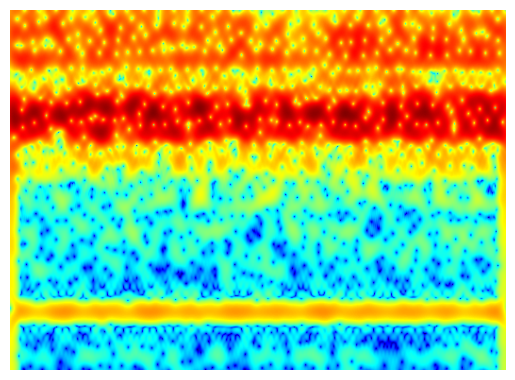

In [14]:
data = np.load("data/processed/cwru/007/B/125_100.npy")
signal, _ = data[:-1], data[-1]
generate_spectrogram(signal, "spectro.png")

In [1]:
from PIL import Image

def check_image_size(image_path):
    """
    Opens an image and prints its dimensions (width, height).
    
    Parameters:
    - image_path: Path to the image file.
    """
    with Image.open(image_path) as img:
        width, height = img.size
        print(f"Image dimensions: {width} x {height} pixels")

# Exemplo de uso
image_path = "data/spectrogram/cwru1_7/B/spectro_007_345.png"  # Substitua pelo caminho da sua imagem
check_image_size(image_path)

Image dimensions: 224 x 224 pixels


Checking the amount of data augmented generated.

In [1]:
from models.cnn1d import CNN1D

for name, layer in CNN1D().named_children():
    print(name, layer)

conv1 Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
bn1 BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
conv2 Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
bn2 BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
conv3 Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
bn3 BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
conv4 Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
bn4 BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
global_pool AdaptiveAvgPool1d(output_size=1)
fc Linear(in_features=128, out_features=4, bias=True)


Gerando dados artificiais misturando os sinais

In [9]:
import os

str(round(os.path.getsize("data/processed/tr_data_mix.h5") / (1024*1024), 2)) + "MB"

'4834.94MB'

Calcular a frequencia em que as falhas ocorrem

In [4]:
import math

class BearingFaultFrequencies:
    @staticmethod
    def bpfo(n, fr, d, D, theta=0):        
        theta_rad = math.radians(theta)
        return (n / 2) * fr * (1 - (d / D) * math.cos(theta_rad))

    @staticmethod
    def bpfi(n, fr, d, D, theta=0):        
        theta_rad = math.radians(theta)
        return (n / 2) * fr * (1 + (d / D) * math.cos(theta_rad))

    @staticmethod
    def bsf(fr, d, D, theta=0):        
        theta_rad = math.radians(theta)
        return (D / (2 * d)) * fr * (1 - ((d / D) * math.cos(theta_rad)) ** 2)

    @staticmethod
    def ftf(fr, d, D, theta=0):       
        theta_rad = math.radians(theta)
        return (1 / 2) * fr * (1 - (d / D) * math.cos(theta_rad))

In [5]:
n = 9  # Número de elementos rolantes
fr = 1773/60  # Frequência de rotação do eixo (Hz)
d = 7.94  # Diâmetro do elemento rolante (mm)
D = 39  # Diâmetro do círculo primitivo (mm)
theta = 0  # Ângulo de contato (graus)

print(f"BPFO: {BearingFaultFrequencies.bpfo(n, fr, d, D, theta):.2f} Hz")
print(f"BPFI: {BearingFaultFrequencies.bpfi(n, fr, d, D, theta):.2f} Hz")
print(f"BSF: {BearingFaultFrequencies.bsf(fr, d, D, theta):.2f} Hz")
print(f"FTF: {BearingFaultFrequencies.ftf(fr, d, D, theta):.2f} Hz")

BPFO: 105.90 Hz
BPFI: 160.05 Hz
BSF: 69.56 Hz
FTF: 11.77 Hz


In [3]:
import os

for i in ["I", "O", "B"]:
    print(len(os.listdir(f"data/spectrogram/cwru_21/{i}")))

355
354
353


### Impulso transiente

Análise do Envelope (Hilbert Transform)

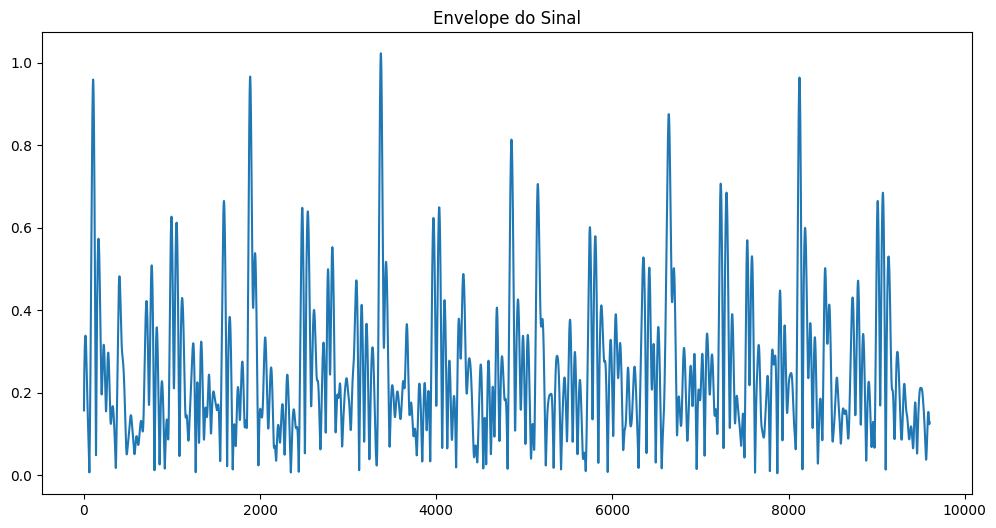

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt

def envelope_signal(signal, fs, lowcut=400, highcut=1600):   
    # Design do filtro passa-banda
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(4, [low, high], btype='band')

    # Filtrando o sinal
    filtered_signal = filtfilt(b, a, signal)
    
    # Calculando o envelope
    envelope = np.abs(hilbert(filtered_signal))
    
    return envelope

# Exemplo de uso
# signal = vetor contendo os dados do sinal de vibração
# fs = taxa de amostragem (Hz)
fs = 48000
filepath = "data/raw/cwru/109.mat"
signal = dataset.load_signal_by_path(filepath)[0][:2*4800]

envelope = envelope_signal(signal, fs)

plt.figure(figsize=(12, 6))
plt.plot(envelope)
plt.title("Envelope do Sinal")
plt.show()


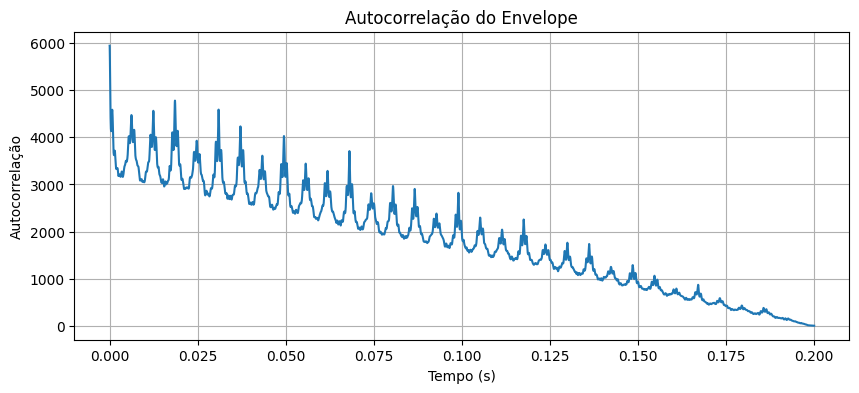

Tamanho do segmento onde os padrões se repetem: 0.0000 segundos


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt, correlate

def bandpass_filter(signal, fs, lowcut=500, highcut=5000):
    """
    Aplica um filtro passa-banda para manter apenas as frequências relevantes.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, signal)

def envelope_autocorrelation(signal, fs):
    """
    Calcula o envelope do sinal via Transformada de Hilbert e aplica a autocorrelação.
    Retorna o tempo entre padrões repetidos.
    """
    # Filtrar o sinal para isolar frequências relevantes
    signal_filtered = bandpass_filter(signal, fs)

    # Aplicar a Transformada de Hilbert para obter o envelope
    envelope = np.abs(hilbert(signal_filtered))

    # Calcular a autocorrelação do envelope
    autocorr = correlate(envelope, envelope, mode='full')
    autocorr = autocorr[len(autocorr) // 2:]  # Considerar apenas valores positivos

    # Encontrar o primeiro pico da autocorrelação (ignorando o pico inicial em lag=0)
    lags = np.arange(len(autocorr)) / fs  # Converter índices para tempo
    peak_lag = lags[np.argmax(autocorr[1:]) + 1]  # +1 para ignorar lag=0

    # Plotar os resultados
    plt.figure(figsize=(10, 4))
    plt.plot(lags, autocorr)
    plt.xlabel("Tempo (s)")
    plt.ylabel("Autocorrelação")
    plt.title("Autocorrelação do Envelope")
    plt.grid()
    plt.show()

    return peak_lag  # Tempo entre padrões repetidos

# Exemplo de uso
fs = 48000  # Taxa de amostragem (Hz)
segment_size = envelope_autocorrelation(signal, fs)
print(f"Tamanho do segmento onde os padrões se repetem: {segment_size:.4f} segundos")


[5.94665925e+03 5.92286427e+03 5.85457450e+03 ... 1.61260857e-01
 9.33322885e-02 2.85366737e-02]


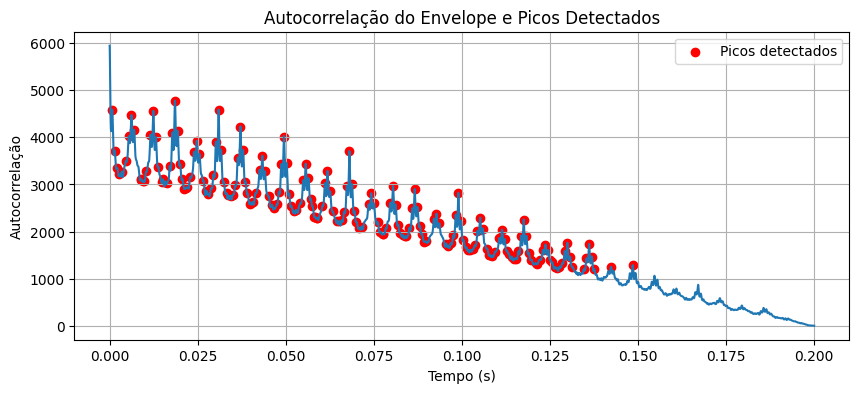

Índices dos segmentos encontrados: [   0   38   76  114  152  190  228  266  304  342  380  418  456  494
  532  570  608  646  684  722  760  798  836  874  912  950  988 1026
 1064 1102 1140 1178 1216 1254 1292 1330 1368 1406 1444 1482 1520 1558
 1596 1634 1672 1710 1748 1786 1824 1862 1900 1938 1976 2014 2052 2090
 2128 2166 2204 2242 2280 2318 2356 2394 2432 2470 2508 2546 2584 2622
 2660 2698 2736 2774 2812 2850 2888 2926 2964 3002 3040 3078 3116 3154
 3192 3230 3268 3306 3344 3382 3420 3458 3496 3534 3572 3610 3648 3686
 3724 3762 3800 3838 3876 3914 3952 3990 4028 4066 4104 4142 4180 4218
 4256 4294 4332 4370 4408 4446 4484 4522 4560 4598 4636 4674 4712 4750
 4788 4826 4864 4902 4940 4978 5016 5054 5092 5130 5168 5206 5244 5282
 5320 5358 5396 5434 5472 5510 5548 5586 5624 5662 5700 5738 5776 5814
 5852 5890 5928 5966 6004 6042 6080 6118 6156 6194 6232 6270 6308 6346
 6384 6422 6460 6498 6536 6574 6612 6650 6688 6726 6764 6802 6840 6878
 6916 6954 6992 7030 7068 7106 7144 7182 7

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt, correlate, find_peaks

def bandpass_filter(signal, fs, lowcut=500, highcut=5000):
    """
    Aplica um filtro passa-banda para remover ruído e manter apenas as frequências relevantes.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, signal)

def segment_signal_by_autocorrelation(signal, fs):
    """
    Separa o sinal em segmentos baseados na periodicidade identificada na autocorrelação do envelope.
    
    :param signal: Sinal de vibração (array)
    :param fs: Taxa de amostragem (Hz)
    :return: Lista de índices onde ocorrem os padrões repetitivos
    """
    # Passo 1: Filtrar o sinal
    signal_filtered = bandpass_filter(signal, fs)

    # Passo 2: Calcular o envelope do sinal via Transformada de Hilbert
    envelope = np.abs(hilbert(signal_filtered))

    # Passo 3: Calcular a autocorrelação do envelope
    autocorr = correlate(envelope, envelope, mode='full')
    autocorr = autocorr[len(autocorr) // 2:]  # Considerar apenas valores positivos
    print(autocorr)

    # Passo 4: Encontrar os picos da autocorrelação para determinar a periodicidade
    lags = np.arange(len(autocorr)) / fs  # Converter índices para tempo (s)
    peaks, _ = find_peaks(autocorr[1:], height=0.2 * max(autocorr))  # Detectar picos relevantes
    peak_lags = lags[peaks]  # Convertendo os índices dos picos para tempos

    # Passo 5: Determinar o intervalo entre os picos (tamanho médio dos segmentos)
    if len(peak_lags) > 1:
        segment_duration = np.mean(np.diff(peak_lags))  # Tempo médio entre picos
    else:
        segment_duration = None  # Se não houver picos suficientes, não segmentamos

    # Passo 6: Obter os índices do sinal original correspondentes aos tempos dos picos
    if segment_duration is not None:
        segment_indices = np.arange(0, len(signal), int(segment_duration * fs))
    else:
        segment_indices = []

    # Exibir a autocorrelação e os picos encontrados
    plt.figure(figsize=(10, 4))
    plt.plot(lags, autocorr)
    plt.scatter(peak_lags, autocorr[peaks], color='red', label="Picos detectados")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Autocorrelação")
    plt.title("Autocorrelação do Envelope e Picos Detectados")
    plt.legend()
    plt.grid()
    plt.show()

    return segment_indices  # Retorna os índices onde ocorrem os segmentos

# Exemplo de uso
fs = 48000  # Taxa de amostragem (Hz)
segment_indices = segment_signal_by_autocorrelation(signal, fs)


print(f"Índices dos segmentos encontrados: {segment_indices}")


Pegando apenas os quatro primeiros picos

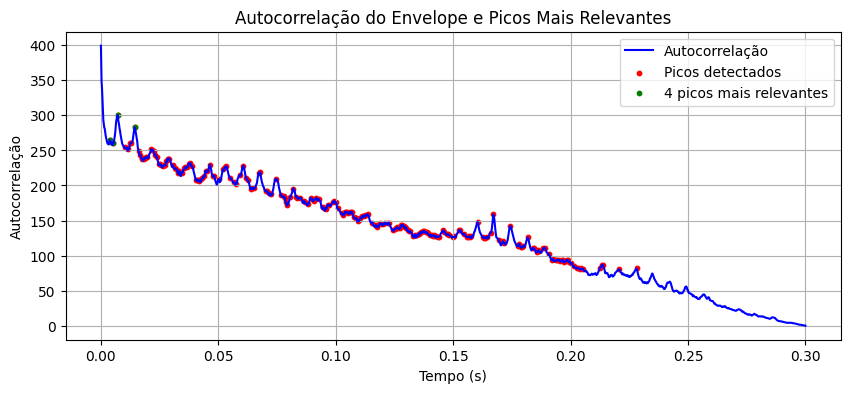

Índices dos 4 picos mais relevantes: [184, 214, 249, 341, 694]
Tempos dos 4 picos mais relevantes (s): [0.00710417 0.01445833 0.00383333 0.00445833 0.0051875 ]


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt, correlate, find_peaks

def bandpass_filter(signal, fs, lowcut=500, highcut=5000):
    """
    Aplica um filtro passa-banda para remover ruído e manter apenas as frequências relevantes.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(4, [low, high], btype='band')
    return filtfilt(b, a, signal)

def detect_top_four_peaks(signal, fs):
    """
    Detecta os 4 picos mais relevantes da autocorrelação do envelope do sinal.
    
    :param signal: Sinal de vibração (array)
    :param fs: Taxa de amostragem (Hz)
    :return: Índices e tempos dos 4 picos mais relevantes
    """
    # Passo 1: Filtrar o sinal
    signal_filtered = bandpass_filter(signal, fs)

    # Passo 2: Calcular o envelope do sinal via Transformada de Hilbert
    envelope = np.abs(hilbert(signal_filtered))

    # Passo 3: Calcular a autocorrelação do envelope
    autocorr = correlate(envelope, envelope, mode='full')
    autocorr = autocorr[len(autocorr) // 2:]  # Considerar apenas valores positivos

    # Passo 4: Criar vetor de tempos correspondente ao eixo X
    lags = np.arange(len(autocorr)) / fs  # Converte índices para tempo (s)

    # Passo 5: Encontrar os picos da autocorrelação
    peaks, properties = find_peaks(autocorr, height=0.2 * max(autocorr))  # Detectar picos relevantes

    # Ordenar os picos pelos valores mais altos (os mais relevantes)
    top_peaks = sorted(peaks, key=lambda i: autocorr[i], reverse=True)[:5]  # Pegamos os 4 picos mais altos
    
    top_peaks_times = lags[top_peaks]  # Convertendo os índices dos picos para tempos

    # Passo 6: Plotar os resultados
    plt.figure(figsize=(10, 4))
    plt.plot(lags, autocorr, label="Autocorrelação", color='blue')
    plt.scatter(lags[peaks], autocorr[peaks], color='red', label="Picos detectados", s=10)  # Todos os picos
    plt.scatter(top_peaks_times, autocorr[top_peaks], color='green', label="4 picos mais relevantes", s=10)  # Picos principais
    plt.xlabel("Tempo (s)")
    plt.ylabel("Autocorrelação")
    plt.title("Autocorrelação do Envelope e Picos Mais Relevantes")
    plt.legend()
    plt.grid()
    plt.show()

    return top_peaks, top_peaks_times

# Exemplo de uso
fs = 48000
filepath = "data/raw/cwru/189.mat"
signal = dataset.load_signal_by_path(filepath)[0][:3*4800]
top_peaks_indices, top_peaks_times = detect_top_four_peaks(signal, fs)

print(f"Índices dos 4 picos mais relevantes: {sorted(top_peaks_indices)}")
print(f"Tempos dos 4 picos mais relevantes (s): {top_peaks_times}")


In [34]:

dataset = CWRU()
dataset_name = "CWRU"
data_filter = load_yaml("config/filters_config.yaml")[dataset_name]
metainfo = dataset.metainfo.filter_data(data_filter)
print(f"Quantidade de arquivos de dados: {len(metainfo)}")

sample_size = []
for info in metainfo:
    basename = info["filename"]       
    filepath = os.path.join('data/raw/', dataset_name.lower(), basename+'.mat')
    # print(f"filepath: {filepath}")            
    signal, label = dataset.load_signal_by_path(filepath)
    sample_size.append(signal.shape[0])
print(f"\nIntervalo do tamanho das amostras: {min(sample_size)} - {max(sample_size)}")

# Parâmetros para o cálculo do impulso transiente
number_of_balls = 9
diameter_ball = 7.94
pitch_diameter = 39.03
shaft_speed = 1773 / 60 # converter para (Hz)
sampling_rate = 48000

# Calculo da frequência da falha
bpfo = BearingFaultFrequencies.calculate_bpfo(shaft_speed, number_of_balls, diameter_ball, pitch_diameter)
bpfi = BearingFaultFrequencies.calculate_bpfi(shaft_speed, number_of_balls, diameter_ball, pitch_diameter)
bsf = BearingFaultFrequencies.calculate_bsf(shaft_speed, number_of_balls, diameter_ball, pitch_diameter)
print(f"\nA frequência das falhas das sequintes classes são:")
print(f"I: {bpfi}, O: {bpfo}, B: {bsf}")

# Calculo do impulso transiente
ti_bpfo = sampling_rate / bpfo
ti_bpfi = sampling_rate / bpfi
ti_bsf = sampling_rate / bsf
print(f"\nO comprimento do segmento do impulso trasiente das sequintes classes são:")
print(f"I: {ti_bpfo}, O: {ti_bpfo}, B: {ti_bsf}")

Quantidade de arquivos de dados: 36

Intervalo do tamanho das amostras: 63788 - 491446

A frequência das falhas das sequintes classes são:
I: 160.02653727901614, O: 105.92346272098385, B: 69.62251670871272

O comprimento do segmento do impulso trasiente das sequintes classes são:
I: 453.1573908836254, O: 453.1573908836254, B: 689.4321301371912
